In [8]:
import matplotlib.pyplot as plt
import scipy.fft as spt  
import numpy as np
import scipy.optimize as so

Text(0, 0.5, 'Average Absolute Magnitude(V)')

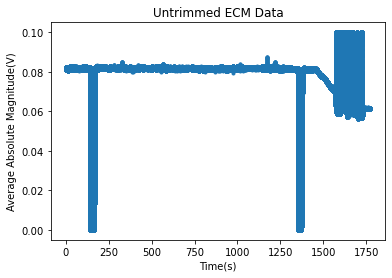

In [9]:
data=np.genfromtxt('20220104-FRB180814.J422+73-T1.csv', delimiter=',')
tdata=[]
mdata=[]
for i in data:
    tdata.append(i[0])
    mdata.append(abs(i[1]))
plt.plot(tdata,mdata,'.')
plt.title('Untrimmed ECM Data')
plt.xlabel('Time(s)')
plt.ylabel('Average Absolute Magnitude(V)')     

0.00032365115810812956


Text(0, 0.5, 'Average Absolute Magnitude(V)')

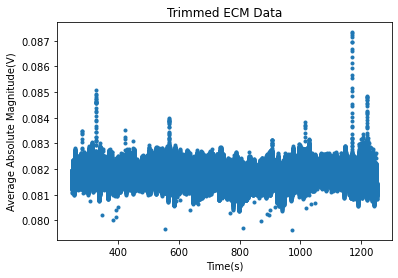

In [10]:
a=250
b=1250
T=b-a
ttdata0=[]
mmdata=[]
for i in range(len(tdata)):
    if tdata[i]>a and tdata[i]<=b:
        ttdata0.append(tdata[i])
        mmdata.append(mdata[i])
ttdata=[]
for i in range(len(ttdata0)):
        ttdata.append(ttdata0[i]-ttdata0[0])

#ttbar=np.sum(ttdata)/len(ttdata)
#for i in ttdata:
norm=np.array(mmdata)-(np.sum(mmdata)/np.size(mmdata))
rms=(np.sum(np.array(norm)**2)/np.size(norm))**0.5  
print(rms)        
        
plt.plot(ttdata0,mmdata,'.')    
plt.title('Trimmed ECM Data')
plt.xlabel('Time(s)')
plt.ylabel('Average Absolute Magnitude(V)')    

In [11]:
def invF(dt,A,xlimf='none',xlimt='none', plot='yes', output='no', absolute='yes',norm='no', positiveoutput='no'): #same as last cell but for inverse transform
    n=np.size(A)
    f=spt.fftfreq(np.size(A),d=dt)
    t=np.arange(0,np.size(A)*dt/2,dt)
    #print(f)
    #print(t)
    #print(A)
    if absolute=='no':
        if norm=='yes':
            Y0=(spt.ifft(A))/np.size(f)
        if norm=='no':
            Y0=(spt.ifft(A))
    if absolute=='yes':
        if norm=='yes':    
            Y0=abs(spt.ifft(A))/np.size(f)
        if norm=='no':
            Y0=abs(spt.ifft(A))
    Y=[]
    for i in range(len(Y0)//2):      #only plots the positive part of the time domain since negative part does not have physical meaning
        Y.append(Y0[i])

    if plot=='yes':
        plt.subplot(1,2,1)
        plt.plot(f,A,'.')
        if xlimf!='none':
            plt.xlim([-xlimf,xlimf])
        plt.xlabel('Frequency(hz)')
        plt.ylabel('Power')
        plt.title('Frequency Domain')
    
        plt.subplot(1,2,2)
        plt.plot(t,Y,'.')
        if xlimt!='none':
            plt.xlim([0,xlimt])
        plt.xlabel('Time(s)')
        plt.ylabel('Magnitude')
        plt.title('Time Domain')
    
    if output=='yes':
        if positiveoutput=='yes':
            return Y
        else:
            return Y0              #negative part of time domain is necessary for further transformation

<ipython-input-18-7f273434e599>:5: RuntimeWarning: divide by zero encountered in true_divide
  S=(1/w)**noise
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1200000
1200000


Text(0, 0.5, 'Average Absolute Magnitude(V)')

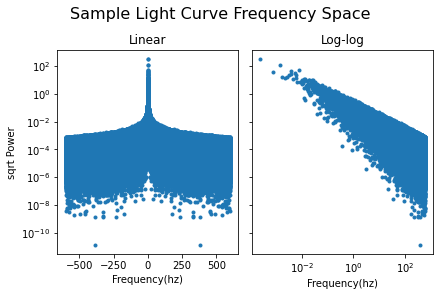

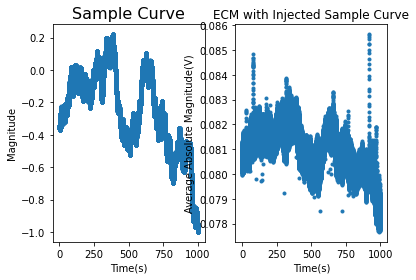

In [18]:
def gendata(T,dt,noise=2,plot=True,output=True):
    n=4*int(T//dt)
    F=spt.fftfreq(n+4,d=dt)
    w=2*np.pi*F
    S=(1/w)**noise
    S[0]=S[1]
    re=[]
    im=[]
    for i in range(len(F)):
        if F[i]>=0:
            r=np.random.normal(0,1,2)
            re.append((0.5*S[i])**0.5*r[0])
    for i in range(len(re)):
        im.append(re[-i])
    y=np.concatenate([re,im])
    Mi=invF(dt,re,output='yes',absolute='no',positiveoutput='yes',plot='no')
    Ma=np.array(Mi)
    M=Ma/np.amax(abs(Ma))
    t=np.arange(0,np.size(M)*dt,dt)
    
    if plot==True:
        fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, sharey=True)
        ax1.plot(F,y,'.')
        ax1.set_title('Linear')
        ax1.set_xlabel('Frequency(hz)')
        ax1.set_ylabel('sqrt Power')
        ax2.loglog(F,y,'.')
        ax2.set_xlabel('Frequency(hz)')
        ax2.set_title('Log-log')
        fig.suptitle('Sample Light Curve Frequency Space', fontsize=16)
    
        plt.figure()
        plt.subplot(1,2,1)
        plt.plot(t,M,'.')
        plt.xlabel('Time(s)')
        plt.ylabel('Magnitude')
        plt.title('Sample Curve',size=16)

    if output==True:
        tr=[]
        mr=[]
        for i in range(len(t)):
            tr.append(t[i])
            mr.append(np.real(M[i]))
        return tr,mr
curve=(gendata(T,1/1200))

print(len(mmdata))
print(len(curve[1]))

strength=10
yinjected=[]
for i in range(len(mmdata)):
    yinjected.append(abs(mmdata[i]+strength*rms*curve[1][i]))
plt.subplot(1,2,2)
plt.plot(ttdata,yinjected,'.')
plt.title('ECM with Injected Sample Curve')
plt.xlabel('Time(s)')
plt.ylabel('Average Absolute Magnitude(V)')  
#plt.xlim(0,10)

0.9332508188444918


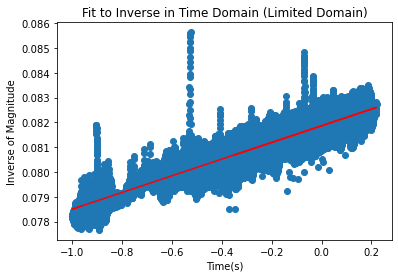

In [19]:
ycurve=np.array(curve[1])
ydata=np.array(yinjected)


def model(t,A,B):
    Y=A*t+B
    return Y

best_params, cov_matrix = so.curve_fit(model, xdata = ycurve, ydata = ydata, p0 = [200,0])
plt.plot(ycurve, model(ycurve, best_params[0], best_params[1]), 'r-', label = 'Fit')
plt.xlabel('Time(s)')
plt.ylabel('Inverse of Magnitude')   
plt.title('Fit to Inverse in Time Domain (Limited Domain)')

corr_matrix = np.corrcoef(ycurve, ydata)
corr = corr_matrix[0,1]

print(corr)

plt.scatter(ycurve, ydata)